# HW3 Image Classification
## We strongly recommend that you run with [Kaggle](https://www.kaggle.com/t/86ca241732c04da99aca6490080bae73) for this homework

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

# Check GPU Type

In [1]:
!nvidia-smi

Mon Jun 10 12:33:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.76                 Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0             17W /   93W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [1]:
# Download Link
# Link 1 (Dropbox): https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
# Link 2 (Google Drive): https://drive.google.com/file/d/1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9/view?usp=share_link
# Link 3: Kaggle Competition.

# (1) dropbox link
#!wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0

# (2) google drive link
#!pip install gdown --upgrade
#!gdown --id '1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9' --output food11.zip

'wget' 不是內部或外部命令、可執行的程式或批次檔。


In [16]:
#!unzip food11.zip

'unzip' 不是內部或外部命令、可執行的程式或批次檔。


# Import Packages

In [1]:
_exp_name = "sample"

In [5]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
#plot
import matplotlib.pyplot as plt
# Pretrained model
from torchvision.models import resnet34, resnet18, vgg16, densenet121, alexnet, squeezenet1_0

In [3]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Transforms
Torchvision provides lots of useful utilities for image preprocessing, data *wrapping* as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [6]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.

    transforms.RandomChoice(transforms=[
        # Apply TrivialAugmentWide data augmentation method
        transforms.TrivialAugmentWide(),

        # Return original image
        transforms.Lambda(lambda x: x),
    ],
                            p=[0.95, 0.05]),

    # ToTensor() should be the last one of the transfo·rms.
    transforms.ToTensor(),
])

# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [7]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files

        self.transform = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)

        try:
            filename = os.path.basename(fname)
            label = int(filename.split("_")[0])
            #label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label

        return im,label

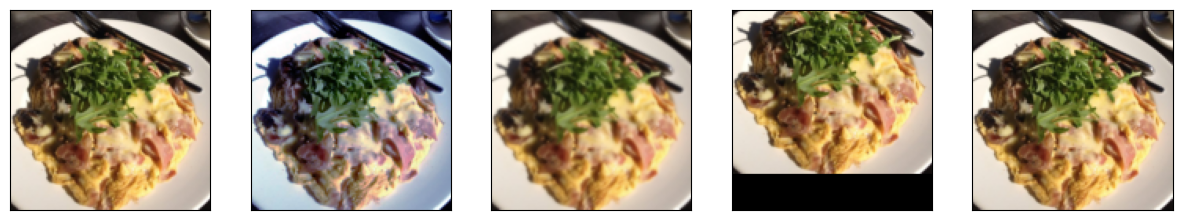

In [6]:
train_dataset = FoodDataset('./train/', tfm=train_tfm)
_, axes = plt.subplots(1, 5, figsize=(15, 50))
axes = axes.flatten()
for i in range(5):
    x,_ = train_dataset[25]
    x = x.permute(1,2,0)
    axes[i].imshow(x.data.numpy())
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)
plt.show()

# Model

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
        
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights=None)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 11)
        self.model.num_classes = 11
        
    
    def forward(self, x):
        return self.model(x)

# Configurations

In [10]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
#model = Classifier().to(device)
model = ResNet18().to(device)

# The number of batch size.
batch_size = 256

# The number of training epochs.
n_epochs = 200

# If no improvement in 'patience' epochs, early stop.
patience = 20

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# Create a learning rate scheduler that reduces the learning rate when the metric stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=patience/2, threshold=0.05)

In [11]:
device

'cuda'

# Dataloader

In [12]:
# Construct train and valid datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("./train", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [10]:
for images, labels in train_loader:
    print(images.shape, labels)

torch.Size([64, 3, 128, 128]) tensor([ 0,  3,  6,  7,  9,  0,  6, 10,  7,  0,  6,  7, 10,  7,  7, 10,  7, 10,
         9, 10,  1,  6,  2,  3,  7, 10,  6,  8,  1,  2,  1,  3, 10,  1,  1,  3,
         9,  6,  7,  6,  2,  3, 10, 10,  9, 10,  9,  9,  3,  7,  3,  1, 10,  0,
         1, 10,  7,  1,  4,  7,  7,  8,  3,  6])
torch.Size([64, 3, 128, 128]) tensor([ 1,  3,  6,  9,  6, 10,  3,  1,  8,  8, 10,  8,  1,  8,  7,  0,  7,  7,
        10,  9,  0,  0, 10,  5,  2, 10,  8,  9,  0,  2, 10,  5,  6,  7,  5,  6,
         4,  3,  7,  3,  0,  6,  1,  6, 10, 10,  3,  1,  2,  1,  4,  7,  2,  7,
        10,  0,  1,  7,  0,  7,  7,  8,  1,  9])
torch.Size([64, 3, 128, 128]) tensor([ 7,  9,  6,  2, 10,  0,  7,  0,  6,  4, 10,  0,  3,  2, 10,  1, 10,  9,
         7,  2, 10,  0,  3,  3,  9,  9,  6,  6,  9,  0,  3, 10,  7,  8,  5,  8,
         6, 10,  0,  7,  8,  7,  1,  6,  7,  1,  7,  4,  5,  0,  1,  3, 10, 10,
         2,  6,  7,  7,  6,  8,  7,  1,  2,  1])
torch.Size([64, 3, 128, 128]) tensor([ 7,  


KeyboardInterrupt



# Start Training

In [13]:
# Create a SummaryWriter object to write data to TensorBoard and the results are stored in ./runs folder
writer = SummaryWriter()

In [16]:
# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/valid', valid_acc, epoch)
    writer.add_scalar('lr', optimizer.state_dict()['param_groups'][0]['lr'], epoch)






    
    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

    # Update learning rate based on the best_acc so far
    scheduler.step(best_acc)

  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 001/200 ] loss = 1.89140, acc = 0.39229


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 001/200 ] loss = 2.40866, acc = 0.27285
[ Valid | 001/200 ] loss = 2.40866, acc = 0.27285 -> best
Best model found at epoch 0, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 002/200 ] loss = 1.82578, acc = 0.42139


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 002/200 ] loss = 1.78479, acc = 0.43129
[ Valid | 002/200 ] loss = 1.78479, acc = 0.43129 -> best
Best model found at epoch 1, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 003/200 ] loss = 1.70366, acc = 0.47305


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 003/200 ] loss = 1.75622, acc = 0.46107
[ Valid | 003/200 ] loss = 1.75622, acc = 0.46107 -> best
Best model found at epoch 2, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 004/200 ] loss = 1.65507, acc = 0.50635


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 004/200 ] loss = 1.90296, acc = 0.42226
[ Valid | 004/200 ] loss = 1.90296, acc = 0.42226


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 005/200 ] loss = 1.53173, acc = 0.56523


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 005/200 ] loss = 2.08064, acc = 0.36245
[ Valid | 005/200 ] loss = 2.08064, acc = 0.36245


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 006/200 ] loss = 1.49083, acc = 0.58105


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 006/200 ] loss = 1.85908, acc = 0.45630
[ Valid | 006/200 ] loss = 1.85908, acc = 0.45630


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 007/200 ] loss = 1.43466, acc = 0.60762


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 007/200 ] loss = 1.80920, acc = 0.46878
[ Valid | 007/200 ] loss = 1.80920, acc = 0.46878 -> best
Best model found at epoch 6, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 008/200 ] loss = 1.35491, acc = 0.64541


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 008/200 ] loss = 1.99286, acc = 0.44154
[ Valid | 008/200 ] loss = 1.99286, acc = 0.44154


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 009/200 ] loss = 1.33402, acc = 0.66680


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 009/200 ] loss = 1.81016, acc = 0.50127
[ Valid | 009/200 ] loss = 1.81016, acc = 0.50127 -> best
Best model found at epoch 8, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 010/200 ] loss = 1.24536, acc = 0.70283


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 010/200 ] loss = 1.74315, acc = 0.48555
[ Valid | 010/200 ] loss = 1.74315, acc = 0.48555


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 011/200 ] loss = 1.21158, acc = 0.71904


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 011/200 ] loss = 1.78577, acc = 0.49813
[ Valid | 011/200 ] loss = 1.78577, acc = 0.49813


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 012/200 ] loss = 1.17047, acc = 0.73984


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 012/200 ] loss = 1.81282, acc = 0.52158
[ Valid | 012/200 ] loss = 1.81282, acc = 0.52158 -> best
Best model found at epoch 11, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 013/200 ] loss = 1.13389, acc = 0.75068


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 013/200 ] loss = 1.81779, acc = 0.52636
[ Valid | 013/200 ] loss = 1.81779, acc = 0.52636 -> best
Best model found at epoch 12, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 014/200 ] loss = 1.11674, acc = 0.75879


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 014/200 ] loss = 1.59967, acc = 0.56645
[ Valid | 014/200 ] loss = 1.59967, acc = 0.56645 -> best
Best model found at epoch 13, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 015/200 ] loss = 1.07338, acc = 0.77812


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 015/200 ] loss = 1.61959, acc = 0.56081
[ Valid | 015/200 ] loss = 1.61959, acc = 0.56081


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 016/200 ] loss = 1.04538, acc = 0.78779


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 016/200 ] loss = 1.59387, acc = 0.56299
[ Valid | 016/200 ] loss = 1.59387, acc = 0.56299


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 017/200 ] loss = 1.05246, acc = 0.79424


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 017/200 ] loss = 1.90511, acc = 0.48407
[ Valid | 017/200 ] loss = 1.90511, acc = 0.48407


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 018/200 ] loss = 1.02877, acc = 0.79756


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 018/200 ] loss = 1.63064, acc = 0.56454
[ Valid | 018/200 ] loss = 1.63064, acc = 0.56454


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 019/200 ] loss = 1.02228, acc = 0.79756


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 019/200 ] loss = 1.76849, acc = 0.53138
[ Valid | 019/200 ] loss = 1.76849, acc = 0.53138


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 020/200 ] loss = 1.02130, acc = 0.80078


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 020/200 ] loss = 1.77966, acc = 0.50056
[ Valid | 020/200 ] loss = 1.77966, acc = 0.50056


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 021/200 ] loss = 1.00676, acc = 0.81299


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 021/200 ] loss = 1.82806, acc = 0.50231
[ Valid | 021/200 ] loss = 1.82806, acc = 0.50231


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 022/200 ] loss = 0.98265, acc = 0.82021


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 022/200 ] loss = 1.58818, acc = 0.56377
[ Valid | 022/200 ] loss = 1.58818, acc = 0.56377


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 023/200 ] loss = 0.96781, acc = 0.82832


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 023/200 ] loss = 1.49151, acc = 0.60605
[ Valid | 023/200 ] loss = 1.49151, acc = 0.60605 -> best
Best model found at epoch 22, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 024/200 ] loss = 0.96324, acc = 0.82764


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 024/200 ] loss = 1.47114, acc = 0.61707
[ Valid | 024/200 ] loss = 1.47114, acc = 0.61707 -> best
Best model found at epoch 23, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 025/200 ] loss = 0.96087, acc = 0.83252


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 025/200 ] loss = 1.56545, acc = 0.58859
[ Valid | 025/200 ] loss = 1.56545, acc = 0.58859


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 026/200 ] loss = 0.94074, acc = 0.83535


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 026/200 ] loss = 1.61054, acc = 0.58425
[ Valid | 026/200 ] loss = 1.61054, acc = 0.58425


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 027/200 ] loss = 0.92131, acc = 0.84473


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 027/200 ] loss = 1.41675, acc = 0.63592
[ Valid | 027/200 ] loss = 1.41675, acc = 0.63592 -> best
Best model found at epoch 26, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 028/200 ] loss = 0.92623, acc = 0.84453


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 028/200 ] loss = 1.62184, acc = 0.58226
[ Valid | 028/200 ] loss = 1.62184, acc = 0.58226


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 029/200 ] loss = 0.92139, acc = 0.84443


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 029/200 ] loss = 1.95961, acc = 0.48276
[ Valid | 029/200 ] loss = 1.95961, acc = 0.48276


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 030/200 ] loss = 0.91671, acc = 0.84678


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 030/200 ] loss = 1.53814, acc = 0.59024
[ Valid | 030/200 ] loss = 1.53814, acc = 0.59024


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 031/200 ] loss = 0.90662, acc = 0.84785


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 031/200 ] loss = 1.51896, acc = 0.59345
[ Valid | 031/200 ] loss = 1.51896, acc = 0.59345


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 032/200 ] loss = 0.91785, acc = 0.84434


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 032/200 ] loss = 1.71527, acc = 0.53060
[ Valid | 032/200 ] loss = 1.71527, acc = 0.53060


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 033/200 ] loss = 0.93723, acc = 0.83379


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 033/200 ] loss = 1.58359, acc = 0.56680
[ Valid | 033/200 ] loss = 1.58359, acc = 0.56680


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 034/200 ] loss = 0.90376, acc = 0.85664


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 034/200 ] loss = 1.57083, acc = 0.58729
[ Valid | 034/200 ] loss = 1.57083, acc = 0.58729


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 035/200 ] loss = 0.86348, acc = 0.86953


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 035/200 ] loss = 1.43222, acc = 0.62124
[ Valid | 035/200 ] loss = 1.43222, acc = 0.62124


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 036/200 ] loss = 0.86696, acc = 0.86641


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 036/200 ] loss = 1.46160, acc = 0.62783
[ Valid | 036/200 ] loss = 1.46160, acc = 0.62783


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 037/200 ] loss = 0.87545, acc = 0.86357


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 037/200 ] loss = 1.52302, acc = 0.59406
[ Valid | 037/200 ] loss = 1.52302, acc = 0.59406


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 038/200 ] loss = 0.84898, acc = 0.87451


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 038/200 ] loss = 1.53062, acc = 0.57852
[ Valid | 038/200 ] loss = 1.53062, acc = 0.57852


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 039/200 ] loss = 0.83844, acc = 0.87861


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 039/200 ] loss = 1.61155, acc = 0.56993
[ Valid | 039/200 ] loss = 1.61155, acc = 0.56993


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 040/200 ] loss = 0.85908, acc = 0.86709


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 040/200 ] loss = 1.48321, acc = 0.59884
[ Valid | 040/200 ] loss = 1.48321, acc = 0.59884


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 041/200 ] loss = 0.84163, acc = 0.87656


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 041/200 ] loss = 1.48314, acc = 0.61881
[ Valid | 041/200 ] loss = 1.48314, acc = 0.61881


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 042/200 ] loss = 0.83983, acc = 0.87861


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 042/200 ] loss = 1.43203, acc = 0.62940
[ Valid | 042/200 ] loss = 1.43203, acc = 0.62940


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 043/200 ] loss = 0.82203, acc = 0.88867


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 043/200 ] loss = 1.48933, acc = 0.61177
[ Valid | 043/200 ] loss = 1.48933, acc = 0.61177


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 044/200 ] loss = 0.83896, acc = 0.87578


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 044/200 ] loss = 1.40938, acc = 0.63383
[ Valid | 044/200 ] loss = 1.40938, acc = 0.63383


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 045/200 ] loss = 0.83136, acc = 0.87832


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 045/200 ] loss = 1.45707, acc = 0.62002
[ Valid | 045/200 ] loss = 1.45707, acc = 0.62002


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 046/200 ] loss = 0.83620, acc = 0.87461


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 046/200 ] loss = 1.39387, acc = 0.64007
[ Valid | 046/200 ] loss = 1.39387, acc = 0.64007 -> best
Best model found at epoch 45, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 047/200 ] loss = 0.81417, acc = 0.88350


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 047/200 ] loss = 1.37321, acc = 0.65335
[ Valid | 047/200 ] loss = 1.37321, acc = 0.65335 -> best
Best model found at epoch 46, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 048/200 ] loss = 0.81358, acc = 0.88682


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 048/200 ] loss = 1.42360, acc = 0.62922
[ Valid | 048/200 ] loss = 1.42360, acc = 0.62922


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 049/200 ] loss = 0.81391, acc = 0.88662


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 049/200 ] loss = 1.38766, acc = 0.65883
[ Valid | 049/200 ] loss = 1.38766, acc = 0.65883 -> best
Best model found at epoch 48, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 050/200 ] loss = 0.80449, acc = 0.89043


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 050/200 ] loss = 1.45750, acc = 0.60760
[ Valid | 050/200 ] loss = 1.45750, acc = 0.60760


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 051/200 ] loss = 0.80595, acc = 0.88818


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 051/200 ] loss = 1.37753, acc = 0.65093
[ Valid | 051/200 ] loss = 1.37753, acc = 0.65093


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 052/200 ] loss = 0.78616, acc = 0.89795


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 052/200 ] loss = 1.38651, acc = 0.63799
[ Valid | 052/200 ] loss = 1.38651, acc = 0.63799


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 053/200 ] loss = 0.78469, acc = 0.89951


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 053/200 ] loss = 1.42668, acc = 0.63270
[ Valid | 053/200 ] loss = 1.42668, acc = 0.63270


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 054/200 ] loss = 0.79913, acc = 0.89258


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 054/200 ] loss = 1.36564, acc = 0.64772
[ Valid | 054/200 ] loss = 1.36564, acc = 0.64772


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 055/200 ] loss = 0.78583, acc = 0.89756


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 055/200 ] loss = 1.48640, acc = 0.60908
[ Valid | 055/200 ] loss = 1.48640, acc = 0.60908


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 056/200 ] loss = 0.78602, acc = 0.89619


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 056/200 ] loss = 1.40812, acc = 0.62844
[ Valid | 056/200 ] loss = 1.40812, acc = 0.62844


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 057/200 ] loss = 0.78542, acc = 0.89775


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 057/200 ] loss = 1.36324, acc = 0.66213
[ Valid | 057/200 ] loss = 1.36324, acc = 0.66213 -> best
Best model found at epoch 56, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 058/200 ] loss = 0.76601, acc = 0.90811


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 058/200 ] loss = 1.34002, acc = 0.65813
[ Valid | 058/200 ] loss = 1.34002, acc = 0.65813


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 059/200 ] loss = 0.77528, acc = 0.90586


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 059/200 ] loss = 1.37443, acc = 0.63850
[ Valid | 059/200 ] loss = 1.37443, acc = 0.63850


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 060/200 ] loss = 0.77079, acc = 0.90410


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 060/200 ] loss = 1.39189, acc = 0.64719
[ Valid | 060/200 ] loss = 1.39189, acc = 0.64719


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 061/200 ] loss = 0.76381, acc = 0.90732


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 061/200 ] loss = 1.37974, acc = 0.64989
[ Valid | 061/200 ] loss = 1.37974, acc = 0.64989


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 062/200 ] loss = 0.76617, acc = 0.90615


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 062/200 ] loss = 1.41332, acc = 0.64078
[ Valid | 062/200 ] loss = 1.41332, acc = 0.64078


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 063/200 ] loss = 0.75174, acc = 0.91025


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 063/200 ] loss = 1.40915, acc = 0.63625
[ Valid | 063/200 ] loss = 1.40915, acc = 0.63625


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 064/200 ] loss = 0.74983, acc = 0.91279


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 064/200 ] loss = 1.34752, acc = 0.66116
[ Valid | 064/200 ] loss = 1.34752, acc = 0.66116


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 065/200 ] loss = 0.75674, acc = 0.91016


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 065/200 ] loss = 1.32550, acc = 0.67576
[ Valid | 065/200 ] loss = 1.32550, acc = 0.67576 -> best
Best model found at epoch 64, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 066/200 ] loss = 0.75945, acc = 0.90684


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 066/200 ] loss = 1.39193, acc = 0.64458
[ Valid | 066/200 ] loss = 1.39193, acc = 0.64458


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 067/200 ] loss = 0.75697, acc = 0.90996


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 067/200 ] loss = 1.36911, acc = 0.66065
[ Valid | 067/200 ] loss = 1.36911, acc = 0.66065


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 068/200 ] loss = 0.74743, acc = 0.91260


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 068/200 ] loss = 1.34936, acc = 0.66169
[ Valid | 068/200 ] loss = 1.34936, acc = 0.66169


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 069/200 ] loss = 0.74484, acc = 0.91514


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 069/200 ] loss = 1.31901, acc = 0.68261
[ Valid | 069/200 ] loss = 1.31901, acc = 0.68261 -> best
Best model found at epoch 68, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 070/200 ] loss = 0.75032, acc = 0.91221


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 070/200 ] loss = 1.35637, acc = 0.65865
[ Valid | 070/200 ] loss = 1.35637, acc = 0.65865


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 071/200 ] loss = 0.75690, acc = 0.90713


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 071/200 ] loss = 1.36445, acc = 0.65066
[ Valid | 071/200 ] loss = 1.36445, acc = 0.65066


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 072/200 ] loss = 0.75606, acc = 0.90957


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 072/200 ] loss = 1.35878, acc = 0.66499
[ Valid | 072/200 ] loss = 1.35878, acc = 0.66499


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 073/200 ] loss = 0.72997, acc = 0.92090


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 073/200 ] loss = 1.36743, acc = 0.65127
[ Valid | 073/200 ] loss = 1.36743, acc = 0.65127


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 074/200 ] loss = 0.73895, acc = 0.91924


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 074/200 ] loss = 1.41665, acc = 0.64328
[ Valid | 074/200 ] loss = 1.41665, acc = 0.64328


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 075/200 ] loss = 0.73271, acc = 0.92061


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 075/200 ] loss = 1.34335, acc = 0.65768
[ Valid | 075/200 ] loss = 1.34335, acc = 0.65768


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 076/200 ] loss = 0.73771, acc = 0.91563


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 076/200 ] loss = 1.45191, acc = 0.62480
[ Valid | 076/200 ] loss = 1.45191, acc = 0.62480


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 077/200 ] loss = 0.73888, acc = 0.91660


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 077/200 ] loss = 1.34526, acc = 0.65596
[ Valid | 077/200 ] loss = 1.34526, acc = 0.65596


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 078/200 ] loss = 0.72950, acc = 0.91846


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 078/200 ] loss = 1.32830, acc = 0.66203
[ Valid | 078/200 ] loss = 1.32830, acc = 0.66203


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 079/200 ] loss = 0.72408, acc = 0.92354


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 079/200 ] loss = 1.29786, acc = 0.68358
[ Valid | 079/200 ] loss = 1.29786, acc = 0.68358 -> best
Best model found at epoch 78, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 080/200 ] loss = 0.72304, acc = 0.92295


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 080/200 ] loss = 1.29938, acc = 0.67549
[ Valid | 080/200 ] loss = 1.29938, acc = 0.67549


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 081/200 ] loss = 0.72318, acc = 0.92363


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 081/200 ] loss = 1.31746, acc = 0.67349
[ Valid | 081/200 ] loss = 1.31746, acc = 0.67349


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 082/200 ] loss = 0.72878, acc = 0.91641


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 082/200 ] loss = 1.32645, acc = 0.67037
[ Valid | 082/200 ] loss = 1.32645, acc = 0.67037


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 083/200 ] loss = 0.73194, acc = 0.91768


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 083/200 ] loss = 1.34700, acc = 0.66360
[ Valid | 083/200 ] loss = 1.34700, acc = 0.66360


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 084/200 ] loss = 0.72337, acc = 0.92080


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 084/200 ] loss = 1.32274, acc = 0.66855
[ Valid | 084/200 ] loss = 1.32274, acc = 0.66855


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 085/200 ] loss = 0.71746, acc = 0.92383


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 085/200 ] loss = 1.31011, acc = 0.67810
[ Valid | 085/200 ] loss = 1.31011, acc = 0.67810


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 086/200 ] loss = 0.72212, acc = 0.92188


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 086/200 ] loss = 1.32856, acc = 0.67289
[ Valid | 086/200 ] loss = 1.32856, acc = 0.67289


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 087/200 ] loss = 0.71422, acc = 0.92529


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 087/200 ] loss = 1.36719, acc = 0.65614
[ Valid | 087/200 ] loss = 1.36719, acc = 0.65614


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 088/200 ] loss = 0.71008, acc = 0.93066


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 088/200 ] loss = 1.29816, acc = 0.67897
[ Valid | 088/200 ] loss = 1.29816, acc = 0.67897


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 089/200 ] loss = 0.70243, acc = 0.93213


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 089/200 ] loss = 1.35691, acc = 0.65943
[ Valid | 089/200 ] loss = 1.35691, acc = 0.65943


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 090/200 ] loss = 0.70108, acc = 0.93057


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 090/200 ] loss = 1.32741, acc = 0.66993
[ Valid | 090/200 ] loss = 1.32741, acc = 0.66993


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 091/200 ] loss = 0.71498, acc = 0.92354


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 091/200 ] loss = 1.33249, acc = 0.67124
[ Valid | 091/200 ] loss = 1.33249, acc = 0.67124


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 092/200 ] loss = 0.70830, acc = 0.92988


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 092/200 ] loss = 1.31624, acc = 0.67202
[ Valid | 092/200 ] loss = 1.31624, acc = 0.67202


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 093/200 ] loss = 0.70596, acc = 0.93027


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 093/200 ] loss = 1.32116, acc = 0.66629
[ Valid | 093/200 ] loss = 1.32116, acc = 0.66629


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 094/200 ] loss = 0.69510, acc = 0.93281


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 094/200 ] loss = 1.31215, acc = 0.67775
[ Valid | 094/200 ] loss = 1.31215, acc = 0.67775


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 095/200 ] loss = 0.69724, acc = 0.93457


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 095/200 ] loss = 1.28859, acc = 0.68235
[ Valid | 095/200 ] loss = 1.28859, acc = 0.68235


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 096/200 ] loss = 0.69454, acc = 0.93203


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 096/200 ] loss = 1.35956, acc = 0.65622
[ Valid | 096/200 ] loss = 1.35956, acc = 0.65622


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 097/200 ] loss = 0.70196, acc = 0.93164


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 097/200 ] loss = 1.30837, acc = 0.68036
[ Valid | 097/200 ] loss = 1.30837, acc = 0.68036


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 098/200 ] loss = 0.68857, acc = 0.93652


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 098/200 ] loss = 1.27762, acc = 0.69138
[ Valid | 098/200 ] loss = 1.27762, acc = 0.69138 -> best
Best model found at epoch 97, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 099/200 ] loss = 0.68040, acc = 0.94189


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 099/200 ] loss = 1.28157, acc = 0.68731
[ Valid | 099/200 ] loss = 1.28157, acc = 0.68731


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 100/200 ] loss = 0.68427, acc = 0.94053


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 100/200 ] loss = 1.28075, acc = 0.68999
[ Valid | 100/200 ] loss = 1.28075, acc = 0.68999


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 101/200 ] loss = 0.68992, acc = 0.93857


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 101/200 ] loss = 1.27818, acc = 0.69911
[ Valid | 101/200 ] loss = 1.27818, acc = 0.69911 -> best
Best model found at epoch 100, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 102/200 ] loss = 0.68008, acc = 0.93828


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 102/200 ] loss = 1.28263, acc = 0.68321
[ Valid | 102/200 ] loss = 1.28263, acc = 0.68321


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 103/200 ] loss = 0.69035, acc = 0.93633


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 103/200 ] loss = 1.31752, acc = 0.67583
[ Valid | 103/200 ] loss = 1.31752, acc = 0.67583


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 104/200 ] loss = 0.68942, acc = 0.93555


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 104/200 ] loss = 1.30170, acc = 0.67565
[ Valid | 104/200 ] loss = 1.30170, acc = 0.67565


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 105/200 ] loss = 0.67016, acc = 0.94355


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 105/200 ] loss = 1.28207, acc = 0.68166
[ Valid | 105/200 ] loss = 1.28207, acc = 0.68166


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 106/200 ] loss = 0.67416, acc = 0.94082


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 106/200 ] loss = 1.35393, acc = 0.66056
[ Valid | 106/200 ] loss = 1.35393, acc = 0.66056


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 107/200 ] loss = 0.67743, acc = 0.94063


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 107/200 ] loss = 1.32148, acc = 0.68096
[ Valid | 107/200 ] loss = 1.32148, acc = 0.68096


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 108/200 ] loss = 0.67624, acc = 0.94102


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 108/200 ] loss = 1.27912, acc = 0.68782
[ Valid | 108/200 ] loss = 1.27912, acc = 0.68782


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 109/200 ] loss = 0.68060, acc = 0.93906


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 109/200 ] loss = 1.27863, acc = 0.68755
[ Valid | 109/200 ] loss = 1.27863, acc = 0.68755


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 110/200 ] loss = 0.68350, acc = 0.93662


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 110/200 ] loss = 1.27921, acc = 0.68973
[ Valid | 110/200 ] loss = 1.27921, acc = 0.68973


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 111/200 ] loss = 0.67368, acc = 0.94473


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 111/200 ] loss = 1.26921, acc = 0.69372
[ Valid | 111/200 ] loss = 1.26921, acc = 0.69372


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 112/200 ] loss = 0.66942, acc = 0.94385


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 112/200 ] loss = 1.24741, acc = 0.70293
[ Valid | 112/200 ] loss = 1.24741, acc = 0.70293 -> best
Best model found at epoch 111, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 113/200 ] loss = 0.67229, acc = 0.94404


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 113/200 ] loss = 1.26722, acc = 0.69451
[ Valid | 113/200 ] loss = 1.26722, acc = 0.69451


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 114/200 ] loss = 0.68092, acc = 0.93828


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 114/200 ] loss = 1.29646, acc = 0.68114
[ Valid | 114/200 ] loss = 1.29646, acc = 0.68114


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 115/200 ] loss = 0.67018, acc = 0.94141


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 115/200 ] loss = 1.28431, acc = 0.69364
[ Valid | 115/200 ] loss = 1.28431, acc = 0.69364


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 116/200 ] loss = 0.66720, acc = 0.94521


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 116/200 ] loss = 1.24133, acc = 0.70423
[ Valid | 116/200 ] loss = 1.24133, acc = 0.70423 -> best
Best model found at epoch 115, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 117/200 ] loss = 0.67025, acc = 0.94531


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 117/200 ] loss = 1.27591, acc = 0.68496
[ Valid | 117/200 ] loss = 1.27591, acc = 0.68496


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 118/200 ] loss = 0.67076, acc = 0.94258


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 118/200 ] loss = 1.24866, acc = 0.70197
[ Valid | 118/200 ] loss = 1.24866, acc = 0.70197


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 119/200 ] loss = 0.66929, acc = 0.94238


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 119/200 ] loss = 1.28434, acc = 0.68625
[ Valid | 119/200 ] loss = 1.28434, acc = 0.68625


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 120/200 ] loss = 0.67510, acc = 0.94111


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 120/200 ] loss = 1.28060, acc = 0.68313
[ Valid | 120/200 ] loss = 1.28060, acc = 0.68313


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 121/200 ] loss = 0.67554, acc = 0.93975


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 121/200 ] loss = 1.27675, acc = 0.68208
[ Valid | 121/200 ] loss = 1.27675, acc = 0.68208


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 122/200 ] loss = 0.67395, acc = 0.94102


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 122/200 ] loss = 1.25467, acc = 0.70320
[ Valid | 122/200 ] loss = 1.25467, acc = 0.70320


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 123/200 ] loss = 0.65956, acc = 0.94844


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 123/200 ] loss = 1.24051, acc = 0.70007
[ Valid | 123/200 ] loss = 1.24051, acc = 0.70007


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 124/200 ] loss = 0.65905, acc = 0.94658


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 124/200 ] loss = 1.25830, acc = 0.69338
[ Valid | 124/200 ] loss = 1.25830, acc = 0.69338


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 125/200 ] loss = 0.66744, acc = 0.94404


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 125/200 ] loss = 1.24266, acc = 0.70249
[ Valid | 125/200 ] loss = 1.24266, acc = 0.70249


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 126/200 ] loss = 0.65440, acc = 0.95000


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 126/200 ] loss = 1.26730, acc = 0.69156
[ Valid | 126/200 ] loss = 1.26730, acc = 0.69156


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 127/200 ] loss = 0.65249, acc = 0.94863


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 127/200 ] loss = 1.24373, acc = 0.69572
[ Valid | 127/200 ] loss = 1.24373, acc = 0.69572


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 128/200 ] loss = 0.65704, acc = 0.94854


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 128/200 ] loss = 1.23486, acc = 0.70684
[ Valid | 128/200 ] loss = 1.23486, acc = 0.70684 -> best
Best model found at epoch 127, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 129/200 ] loss = 0.65152, acc = 0.95059


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 129/200 ] loss = 1.25532, acc = 0.69901
[ Valid | 129/200 ] loss = 1.25532, acc = 0.69901


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 130/200 ] loss = 0.65433, acc = 0.94932


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 130/200 ] loss = 1.25673, acc = 0.69511
[ Valid | 130/200 ] loss = 1.25673, acc = 0.69511


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 131/200 ] loss = 0.65863, acc = 0.94756


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 131/200 ] loss = 1.27567, acc = 0.68773
[ Valid | 131/200 ] loss = 1.27567, acc = 0.68773


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 132/200 ] loss = 0.64714, acc = 0.95244


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 132/200 ] loss = 1.26426, acc = 0.69875
[ Valid | 132/200 ] loss = 1.26426, acc = 0.69875


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 133/200 ] loss = 0.65095, acc = 0.94932


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 133/200 ] loss = 1.25663, acc = 0.69954
[ Valid | 133/200 ] loss = 1.25663, acc = 0.69954


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 134/200 ] loss = 0.64756, acc = 0.95117


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 134/200 ] loss = 1.25367, acc = 0.69666
[ Valid | 134/200 ] loss = 1.25367, acc = 0.69666


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 135/200 ] loss = 0.65381, acc = 0.94941


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 135/200 ] loss = 1.26575, acc = 0.69555
[ Valid | 135/200 ] loss = 1.26575, acc = 0.69555


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 136/200 ] loss = 0.65388, acc = 0.94922


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 136/200 ] loss = 1.24137, acc = 0.69643
[ Valid | 136/200 ] loss = 1.24137, acc = 0.69643


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 137/200 ] loss = 0.65190, acc = 0.95059


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 137/200 ] loss = 1.26312, acc = 0.69597
[ Valid | 137/200 ] loss = 1.26312, acc = 0.69597


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 138/200 ] loss = 0.65143, acc = 0.94873


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 138/200 ] loss = 1.25196, acc = 0.70205
[ Valid | 138/200 ] loss = 1.25196, acc = 0.70205


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 139/200 ] loss = 0.65956, acc = 0.94619


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 139/200 ] loss = 1.23487, acc = 0.70753
[ Valid | 139/200 ] loss = 1.23487, acc = 0.70753 -> best
Best model found at epoch 138, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 140/200 ] loss = 0.65908, acc = 0.94697


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 140/200 ] loss = 1.25990, acc = 0.69737
[ Valid | 140/200 ] loss = 1.25990, acc = 0.69737


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 141/200 ] loss = 0.64444, acc = 0.95264


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 141/200 ] loss = 1.23616, acc = 0.69902
[ Valid | 141/200 ] loss = 1.23616, acc = 0.69902


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 142/200 ] loss = 0.65415, acc = 0.94932


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 142/200 ] loss = 1.23582, acc = 0.70301
[ Valid | 142/200 ] loss = 1.23582, acc = 0.70301


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 143/200 ] loss = 0.64662, acc = 0.95225


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 143/200 ] loss = 1.24386, acc = 0.70233
[ Valid | 143/200 ] loss = 1.24386, acc = 0.70233


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 144/200 ] loss = 0.64996, acc = 0.95186


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 144/200 ] loss = 1.22983, acc = 0.70779
[ Valid | 144/200 ] loss = 1.22983, acc = 0.70779 -> best
Best model found at epoch 143, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 145/200 ] loss = 0.65038, acc = 0.94980


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 145/200 ] loss = 1.24161, acc = 0.70206
[ Valid | 145/200 ] loss = 1.24161, acc = 0.70206


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 146/200 ] loss = 0.64684, acc = 0.95625


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 146/200 ] loss = 1.26003, acc = 0.69806
[ Valid | 146/200 ] loss = 1.26003, acc = 0.69806


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 147/200 ] loss = 0.64194, acc = 0.95547


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 147/200 ] loss = 1.24269, acc = 0.70944
[ Valid | 147/200 ] loss = 1.24269, acc = 0.70944 -> best
Best model found at epoch 146, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 148/200 ] loss = 0.64348, acc = 0.95488


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 148/200 ] loss = 1.23454, acc = 0.70867
[ Valid | 148/200 ] loss = 1.23454, acc = 0.70867


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 149/200 ] loss = 0.64065, acc = 0.95498


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 149/200 ] loss = 1.24728, acc = 0.70102
[ Valid | 149/200 ] loss = 1.24728, acc = 0.70102


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 150/200 ] loss = 0.64462, acc = 0.95068


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 150/200 ] loss = 1.23099, acc = 0.70935
[ Valid | 150/200 ] loss = 1.23099, acc = 0.70935


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 151/200 ] loss = 0.64191, acc = 0.95352


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 151/200 ] loss = 1.25864, acc = 0.69692
[ Valid | 151/200 ] loss = 1.25864, acc = 0.69692


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 152/200 ] loss = 0.64572, acc = 0.95273


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 152/200 ] loss = 1.24035, acc = 0.70822
[ Valid | 152/200 ] loss = 1.24035, acc = 0.70822


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 153/200 ] loss = 0.63997, acc = 0.95605


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 153/200 ] loss = 1.23734, acc = 0.70276
[ Valid | 153/200 ] loss = 1.23734, acc = 0.70276


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 154/200 ] loss = 0.64446, acc = 0.95254


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 154/200 ] loss = 1.23204, acc = 0.70388
[ Valid | 154/200 ] loss = 1.23204, acc = 0.70388


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 155/200 ] loss = 0.64046, acc = 0.95527


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 155/200 ] loss = 1.23210, acc = 0.70675
[ Valid | 155/200 ] loss = 1.23210, acc = 0.70675


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 156/200 ] loss = 0.63119, acc = 0.95771


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 156/200 ] loss = 1.23595, acc = 0.70483
[ Valid | 156/200 ] loss = 1.23595, acc = 0.70483


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 157/200 ] loss = 0.63604, acc = 0.95713


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 157/200 ] loss = 1.23449, acc = 0.70492
[ Valid | 157/200 ] loss = 1.23449, acc = 0.70492


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 158/200 ] loss = 0.63492, acc = 0.95781


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 158/200 ] loss = 1.24690, acc = 0.70700
[ Valid | 158/200 ] loss = 1.24690, acc = 0.70700


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 159/200 ] loss = 0.64044, acc = 0.95713


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 159/200 ] loss = 1.22663, acc = 0.71230
[ Valid | 159/200 ] loss = 1.22663, acc = 0.71230 -> best
Best model found at epoch 158, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 160/200 ] loss = 0.64768, acc = 0.95049


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 160/200 ] loss = 1.23290, acc = 0.70874
[ Valid | 160/200 ] loss = 1.23290, acc = 0.70874


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 161/200 ] loss = 0.62890, acc = 0.96006


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 161/200 ] loss = 1.25182, acc = 0.70335
[ Valid | 161/200 ] loss = 1.25182, acc = 0.70335


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 162/200 ] loss = 0.63591, acc = 0.95781


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 162/200 ] loss = 1.24589, acc = 0.70527
[ Valid | 162/200 ] loss = 1.24589, acc = 0.70527


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 163/200 ] loss = 0.63869, acc = 0.95762


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 163/200 ] loss = 1.25315, acc = 0.70292
[ Valid | 163/200 ] loss = 1.25315, acc = 0.70292


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 164/200 ] loss = 0.63304, acc = 0.95713


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 164/200 ] loss = 1.24953, acc = 0.70492
[ Valid | 164/200 ] loss = 1.24953, acc = 0.70492


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 165/200 ] loss = 0.63711, acc = 0.95684


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 165/200 ] loss = 1.24312, acc = 0.70753
[ Valid | 165/200 ] loss = 1.24312, acc = 0.70753


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 166/200 ] loss = 0.63637, acc = 0.95732


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 166/200 ] loss = 1.22514, acc = 0.71335
[ Valid | 166/200 ] loss = 1.22514, acc = 0.71335 -> best
Best model found at epoch 165, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 167/200 ] loss = 0.63406, acc = 0.95742


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 167/200 ] loss = 1.22763, acc = 0.71048
[ Valid | 167/200 ] loss = 1.22763, acc = 0.71048


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 168/200 ] loss = 0.63462, acc = 0.95703


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 168/200 ] loss = 1.27674, acc = 0.69372
[ Valid | 168/200 ] loss = 1.27674, acc = 0.69372


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 169/200 ] loss = 0.63690, acc = 0.95547


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 169/200 ] loss = 1.25053, acc = 0.70283
[ Valid | 169/200 ] loss = 1.25053, acc = 0.70283


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 170/200 ] loss = 0.64114, acc = 0.95381


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 170/200 ] loss = 1.23922, acc = 0.70440
[ Valid | 170/200 ] loss = 1.23922, acc = 0.70440


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 171/200 ] loss = 0.64023, acc = 0.95391


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 171/200 ] loss = 1.23555, acc = 0.70857
[ Valid | 171/200 ] loss = 1.23555, acc = 0.70857


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 172/200 ] loss = 0.62821, acc = 0.95762


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 172/200 ] loss = 1.22807, acc = 0.71370
[ Valid | 172/200 ] loss = 1.22807, acc = 0.71370 -> best
Best model found at epoch 171, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 173/200 ] loss = 0.62946, acc = 0.96182


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 173/200 ] loss = 1.23204, acc = 0.70839
[ Valid | 173/200 ] loss = 1.23204, acc = 0.70839


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 174/200 ] loss = 0.62921, acc = 0.95938


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 174/200 ] loss = 1.25170, acc = 0.69615
[ Valid | 174/200 ] loss = 1.25170, acc = 0.69615


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 175/200 ] loss = 0.63470, acc = 0.95703


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 175/200 ] loss = 1.23271, acc = 0.71118
[ Valid | 175/200 ] loss = 1.23271, acc = 0.71118


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 176/200 ] loss = 0.63223, acc = 0.95908


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 176/200 ] loss = 1.23996, acc = 0.69945
[ Valid | 176/200 ] loss = 1.23996, acc = 0.69945


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 177/200 ] loss = 0.64200, acc = 0.95146


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 177/200 ] loss = 1.22546, acc = 0.71517
[ Valid | 177/200 ] loss = 1.22546, acc = 0.71517 -> best
Best model found at epoch 176, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 178/200 ] loss = 0.62863, acc = 0.96191


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 178/200 ] loss = 1.23631, acc = 0.70613
[ Valid | 178/200 ] loss = 1.23631, acc = 0.70613


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 179/200 ] loss = 0.62588, acc = 0.96211


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 179/200 ] loss = 1.23020, acc = 0.70553
[ Valid | 179/200 ] loss = 1.23020, acc = 0.70553


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 180/200 ] loss = 0.63338, acc = 0.95908


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 180/200 ] loss = 1.23882, acc = 0.71065
[ Valid | 180/200 ] loss = 1.23882, acc = 0.71065


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 181/200 ] loss = 0.63999, acc = 0.95430


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 181/200 ] loss = 1.21967, acc = 0.71552
[ Valid | 181/200 ] loss = 1.21967, acc = 0.71552 -> best
Best model found at epoch 180, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 182/200 ] loss = 0.62442, acc = 0.95967


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 182/200 ] loss = 1.22456, acc = 0.70588
[ Valid | 182/200 ] loss = 1.22456, acc = 0.70588


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 183/200 ] loss = 0.63570, acc = 0.95674


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 183/200 ] loss = 1.22884, acc = 0.71291
[ Valid | 183/200 ] loss = 1.22884, acc = 0.71291


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 184/200 ] loss = 0.63142, acc = 0.95928


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 184/200 ] loss = 1.21992, acc = 0.71847
[ Valid | 184/200 ] loss = 1.21992, acc = 0.71847 -> best
Best model found at epoch 183, saving model


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 185/200 ] loss = 0.62815, acc = 0.95967


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 185/200 ] loss = 1.22263, acc = 0.71430
[ Valid | 185/200 ] loss = 1.22263, acc = 0.71430


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 186/200 ] loss = 0.62097, acc = 0.96338


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 186/200 ] loss = 1.22625, acc = 0.71343
[ Valid | 186/200 ] loss = 1.22625, acc = 0.71343


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 187/200 ] loss = 0.62470, acc = 0.96221


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 187/200 ] loss = 1.23719, acc = 0.70770
[ Valid | 187/200 ] loss = 1.23719, acc = 0.70770


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 188/200 ] loss = 0.61902, acc = 0.96436


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 188/200 ] loss = 1.21555, acc = 0.71413
[ Valid | 188/200 ] loss = 1.21555, acc = 0.71413


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 189/200 ] loss = 0.62950, acc = 0.95869


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 189/200 ] loss = 1.24541, acc = 0.69840
[ Valid | 189/200 ] loss = 1.24541, acc = 0.69840


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 190/200 ] loss = 0.63443, acc = 0.95605


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 190/200 ] loss = 1.24578, acc = 0.69779
[ Valid | 190/200 ] loss = 1.24578, acc = 0.69779


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 191/200 ] loss = 0.62963, acc = 0.96025


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 191/200 ] loss = 1.22391, acc = 0.71343
[ Valid | 191/200 ] loss = 1.22391, acc = 0.71343


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 192/200 ] loss = 0.62336, acc = 0.96348


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 192/200 ] loss = 1.24877, acc = 0.70439
[ Valid | 192/200 ] loss = 1.24877, acc = 0.70439


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 193/200 ] loss = 0.62087, acc = 0.96348


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 193/200 ] loss = 1.24372, acc = 0.70483
[ Valid | 193/200 ] loss = 1.24372, acc = 0.70483


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 194/200 ] loss = 0.62904, acc = 0.96191


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 194/200 ] loss = 1.23445, acc = 0.71048
[ Valid | 194/200 ] loss = 1.23445, acc = 0.71048


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 195/200 ] loss = 0.62049, acc = 0.96377


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 195/200 ] loss = 1.21599, acc = 0.71821
[ Valid | 195/200 ] loss = 1.21599, acc = 0.71821


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 196/200 ] loss = 0.63304, acc = 0.95625


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 196/200 ] loss = 1.21421, acc = 0.71491
[ Valid | 196/200 ] loss = 1.21421, acc = 0.71491


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 197/200 ] loss = 0.62050, acc = 0.96172


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 197/200 ] loss = 1.21563, acc = 0.71734
[ Valid | 197/200 ] loss = 1.21563, acc = 0.71734


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 198/200 ] loss = 0.62460, acc = 0.96279


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 198/200 ] loss = 1.22280, acc = 0.71039
[ Valid | 198/200 ] loss = 1.22280, acc = 0.71039


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 199/200 ] loss = 0.61418, acc = 0.96670


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 199/200 ] loss = 1.21828, acc = 0.71474
[ Valid | 199/200 ] loss = 1.21828, acc = 0.71474


  0%|          | 0/40 [00:00<?, ?it/s]

[ Train | 200/200 ] loss = 0.61650, acc = 0.96504


  0%|          | 0/15 [00:00<?, ?it/s]

[ Valid | 200/200 ] loss = 1.23079, acc = 0.71004
[ Valid | 200/200 ] loss = 1.23079, acc = 0.71004


Support for third party widgets will remain active for the duration of the session. To disable support:

# Dataloader for test

In [17]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset("./test", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Testing and generate prediction CSV

In [19]:
model_best = ResNet18().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

  0%|          | 0/12 [00:00<?, ?it/s]

In [20]:
# create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

# TensorBoard

In [21]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

Reusing TensorBoard on port 6006 (pid 33536), started 6:21:52 ago. (Use '!kill 33536' to kill it.)

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice.
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [22]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You can add some transforms here.
    transforms.ToTensor(),
])

# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images).


In [24]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
model = ResNet18().to(device)
state_dict = torch.load(f"{_exp_name}_best.ckpt")
model.load_state_dict(state_dict)
model.eval()

print(model)

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [27]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 4 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)

features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
labels = [0]
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()

  0%|          | 0/57 [00:00<?, ?it/s]


TypeError: 'ResNet' object is not subscriptable